## Imports and setup
TensorFlow 2.4 or higher

In [1]:
# !pip install -U tensorflow-addons

In [2]:
# !pip install tensorflow

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Mar 24 17:48:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   37C    P8    35W / 350W |    522MiB / 24576MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 134.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import scipy.io
import shutil

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

2023-03-24 17:48:53.132421: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 17:48:53.133610: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-24 17:48:53.156247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-24 17:48:53.156746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 17:48:53.492626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
PATH_2_TRAINING_IMGS = 'datasets/17kGraffiti/split/train/graffiti/'

# DataFrame,dictionary of lists, unpickled_data
train_bboxes = pd.read_pickle('datasets/17kGraffiti/train_bboxes.pkl')
test_bboxes = pd.read_pickle('datasets/17kGraffiti/test_bboxes.pkl')

In [8]:
train_bboxes

,FileName,bbox_count,bbox
0,10005452375_1fc378fb7f_c,1,"[[103, 93, 572, 436]]"
1,10005549113_1057d20b58_c,1,"[[106, 30, 659, 533]]"
2,10007929605_a3e9d26cd7_c,1,"[[5, 286, 781, 645]]"
3,10008858965_1fe2600f5e_c,1,"[[34, 13, 770, 584]]"
4,10008863645_708e989a49_c,1,"[[7, 84, 781, 511]]"
...,...,...,...
6944,15640582872_439a34a52a_c,3,"[[57, 31, 396, 180], [62, 185, 750, 432], [617..."
6945,16140222002_796ffede5a_c,5,"[[323, 13, 613, 238], [536, 253, 738, 403], [2..."
6946,26597962666_0353e3e77d_c,1,"[[32, 123, 776, 437]]"
6947,30870264967_a5deb8cdf8_c,11,"[[31, 106, 142, 204], [143, 119, 317, 208], [3..."


### Getting the image path via listdir

In [9]:
path_images = 'datasets/17kGraffiti/split/train/graffiti/'
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
#image_paths.sort()
#image_paths

In [10]:
# print(str(train_bboxes)[1:-1])

### Getting the image path via DataFrame

In [11]:
#image_paths = train_bboxes.iloc[:,0].to_list()
image_paths = []
image_paths = train_bboxes.loc[:,"FileName"].to_list()
#image_paths.sort()
image_paths

['10005452375_1fc378fb7f_c',
 '10005549113_1057d20b58_c',
 '10007929605_a3e9d26cd7_c',
 '10008858965_1fe2600f5e_c',
 '10008863645_708e989a49_c',
 '10008916523_57e1215f5a_c',
 '10008971653_d32f09b87b_c',
 '10009017873_ac4b0ee3e7_c',
 '1001180412_34f6721f04_c',
 '10034338656_423b52122d_c',
 '10034339546_8a2486cbc9_c',
 '10041596723_a97ea3fce3_c',
 '10058117206_107250e5d6_c',
 '10058121946_5aa3e789d4_c',
 '10058123315_d6ab2a10c9_c',
 '10078846263_3916129ff4_c',
 '10086968375_e783307e3f_c',
 '10112385716_4d26f591c0_c',
 '10112431913_06b2dfb89a_c',
 '10121238944_4e2df78072_c',
 '10121315255_704a0ef798_c',
 '10121326145_df091e3dd8_c',
 '10121341196_e9b256e830_c',
 '10121364976_68f7db86d9_c',
 '10136335585_9ff7331c42_c',
 '10145652984_bdf5688c7d_c',
 '10145906425_7b00bde882_c',
 '10145981986_726ed9c559_c',
 '10153207706_3b30990185_c',
 '10158412754_5229b52c5f_c',
 '10167902364_9545fac49f_c',
 '10176958613_b18f21e8a6_c',
 '10185187695_39e7589395_c',
 '10185300873_e986dbb16c_c',
 '10187467316_8

In [12]:
#train_bboxes[0:-1]
annot_paths = []
annot_paths = train_bboxes.loc[:,"bbox"].to_list()
#listBoxes =  list(train_bboxes["bbox"])
#print(listBoxes)
annot_paths

[array([[103,  93, 572, 436]], dtype=int32),
 array([[106,  30, 659, 533]], dtype=int32),
 array([[  5, 286, 781, 645]], dtype=int32),
 array([[ 34,  13, 770, 584]], dtype=int32),
 array([[  7,  84, 781, 511]], dtype=int32),
 array([[ 15,  67, 790, 511]], dtype=int32),
 array([[ 66, 105, 757, 505]], dtype=int32),
 array([[  9,  83, 757, 498]], dtype=int32),
 array([[  7,  15, 735, 494]], dtype=int32),
 array([[ 83,  36, 778, 358]], dtype=int32),
 array([[ 15,  40, 775, 342]], dtype=int32),
 array([[153, 269, 770, 442]], dtype=int32),
 array([[ 82, 127, 751, 305]], dtype=int32),
 array([[ 39,  57, 786, 385]], dtype=int32),
 array([[ 38,  12, 733, 306]], dtype=int32),
 array([[ 35,  17, 750, 474]], dtype=int32),
 array([[ 18, 283, 782, 699]], dtype=int32),
 array([[ 43,   9, 765, 271]], dtype=int32),
 array([[ 13,  19, 775, 417]], dtype=int32),
 array([[ 74, 116, 782, 343]], dtype=int32),
 array([[ 47, 148, 786, 434]], dtype=int32),
 array([[ 68, 185, 768, 359]], dtype=int32),
 array([[ 

## Prepare the dataset ToyExample
Caltech 101 Dataset

In [13]:
# Path to images and annotations
path_images = "datasets/caltech-101/101_ObjectCategories/airplanes/"
path_annot = "datasets/caltech-101/Annotations/Airplanes_Side_2/"

path_to_downloaded_file = keras.utils.get_file(
    fname="caltech_101_zipped",
    origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",  # downloaded file format
    cache_dir="./",  # cache and extract in current directory
)

In [14]:
# Extracting tar files found inside main zip file
shutil.unpack_archive("datasets/caltech-101/101_ObjectCategories.tar.gz", "datasets/caltech-101/")
shutil.unpack_archive("datasets/caltech-101/Annotations.tar", "datasets/caltech-101/")

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

In [ ]:
#annot_paths

In [15]:
image_size = 224  # resize input images to this size

images, targets = [], []

In [16]:
#annot = scipy.io.loadmat(path_annot + annot_paths[0])["box_coord"][0]
#annot

In [17]:
# loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    
    image = keras.utils.load_img(
        path_images + image_paths[i],
    )
    (w, h) = image.size[:2]

    # resize train set images
    if i < int(len(annot_paths) * 0.8):
        # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))
    
    # Access bounding box coordinates
    annot_file = scipy.io.loadmat(path_annot + annot_paths[i])
    
    sub_targets = []
    for annot in annot_file["box_coord"]:

        top_left_x, top_left_y = annot[2], annot[0]
        bottom_right_x, bottom_right_y = annot[3], annot[1]

        # apply relative scaling to bounding boxes as per given image and append to list
        sub_targets.append(
            (
                float(top_left_x) / w,
                float(top_left_y) / h,
                float(bottom_right_x) / w,
                float(bottom_right_y) / h,
            )
        )
        
    targets.append(sub_targets)


In [18]:
annot_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Dec 27 14:01:06 2004',
 '__version__': '1.0',
 '__globals__': [],
 'box_coord': array([[ 27, 109,  53, 348]], dtype=uint16),
 'obj_contour': array([[140.29435484,  94.34274194,  18.85080645,  18.85080645,
          23.3266129 ,   0.94758065,  13.47983871,  35.26209677,
          18.55241935,  30.48790323,  71.06854839, 108.96370968,
          85.98790323,  90.46370968,  65.39919355,  77.03629032,
         148.94758065, 196.09274194, 246.52016129, 266.51209677,
         288.89112903, 294.56048387, 294.56048387, 286.50403226,
         277.25403226, 276.65725806, 273.97177419, 273.6733871 ,
         264.4233871 , 264.4233871 , 217.5766129 , 218.1733871 ,
         193.70564516, 193.70564516, 186.84274194, 181.77016129,
         174.01209677, 170.13306452, 167.44758065, 173.11693548,
         172.22177419, 157.00403226, 150.73790323, 160.88306452,
         158.19758065, 141.78629032, 135.81854839, 143.5766129 ,
         

In [19]:
# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)  

/tmp/ipykernel_686260/4234801415.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8) :]),


## Implement multilayer-perceptron (MLP)

In [20]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement the patch creation layer

In [21]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

## Display patches for an input image

In [22]:
x_train

array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

In [27]:
y_train

array([[[0.12311558, 0.18292683, 0.87688442, 0.83536585]],

       [[0.14713217, 0.19021739, 0.85286783, 0.83152174]],

       [[0.11959288, 0.21818182, 0.84223919, 0.81818182]],

       ...,

       [[0.13647643, 0.17857143, 0.87096774, 0.83928571]],

       [[0.13283208, 0.17365269, 0.87468672, 0.83832335]],

       [[0.12531328, 0.18181818, 0.86967419, 0.83116883]]])

2023-03-24 17:51:13.353571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-24 17:51:13.353811: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


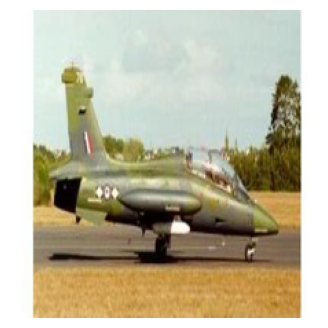

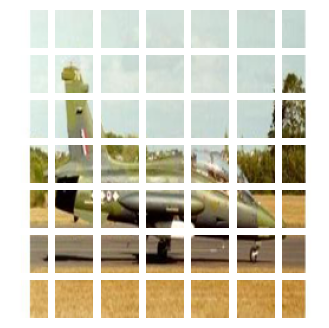

In [23]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

In [24]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

In [25]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

## Run the experiment

In [26]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
18/18 [==============================] - 4s 146ms/step - loss: 0.9555 - val_loss: 0.3431
Epoch 2/100
18/18 [==============================] - 2s 130ms/step - loss: 0.3720 - val_loss: 0.3022
Epoch 3/100
18/18 [==============================] - 2s 126ms/step - loss: 0.2912 - val_loss: 0.2604
Epoch 4/100
18/18 [==============================] - 2s 128ms/step - loss: 0.2466 - val_loss: 0.2227
Epoch 5/100
18/18 [==============================] - 2s 138ms/step - loss: 0.1973 - val_loss: 0.0634
Epoch 6/100
18/18 [==============================] - 2s 127ms/step - loss: 0.1186 - val_loss: 0.0382
Epoch 7/100
18/18 [==============================] - 2s 109ms/step - loss: 0.0567 - val_loss: 0.0020
Epoch 8/100
18/18 [==============================] - 2s 118ms/step - loss: 0.0357 - val_loss: 0.0019
Epoch 9/100
18/18 [==============================] - 2s 101ms/step - loss: 0.0274 - val_loss: 0.0029
Epoch 10/100
18/18 [==============================] - 2s 115ms/step - loss: 0.0256 - val_lo

## Evaluate the model

1/1 [==============================] - 0s 13ms/step
[61, 33, 362, 136] [56, 28, 349, 133]
1/1 [==============================] - 0s 13ms/step
[60, 31, 355, 127] [50, 29, 348, 121]
1/1 [==============================] - 0s 12ms/step
[60, 25, 355, 102] [48, 25, 344, 98]
1/1 [==============================] - 0s 13ms/step
[60, 35, 358, 142] [49, 30, 349, 140]
1/1 [==============================] - 0s 12ms/step
[62, 26, 366, 109] [58, 31, 349, 99]
1/1 [==============================] - 0s 12ms/step
[61, 38, 362, 154] [61, 33, 348, 151]
1/1 [==============================] - 0s 12ms/step
[62, 38, 365, 155] [56, 37, 353, 156]
1/1 [==============================] - 0s 13ms/step
[62, 34, 371, 140] [59, 36, 355, 133]
1/1 [==============================] - 0s 12ms/step
[61, 27, 361, 111] [50, 26, 352, 98]
1/1 [==============================] - 0s 12ms/step
[61, 35, 362, 143] [29, 32, 348, 140]
1/1 [==============================] - 0s 13ms/step
[62, 29, 369, 120] [63, 29, 354, 111]
1/1 [========

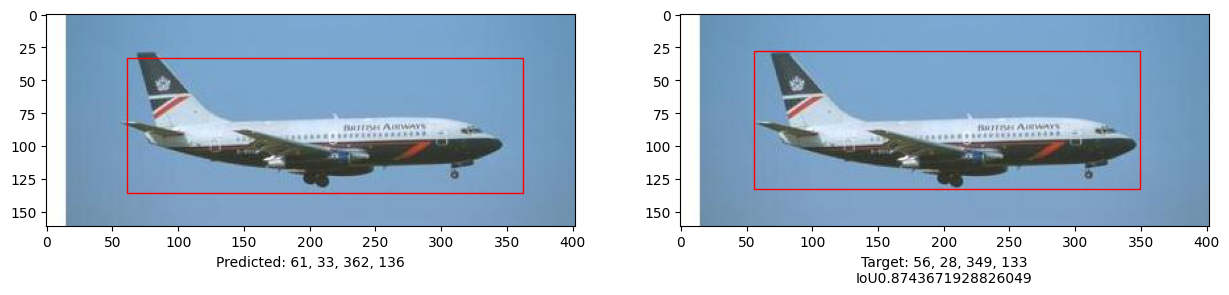

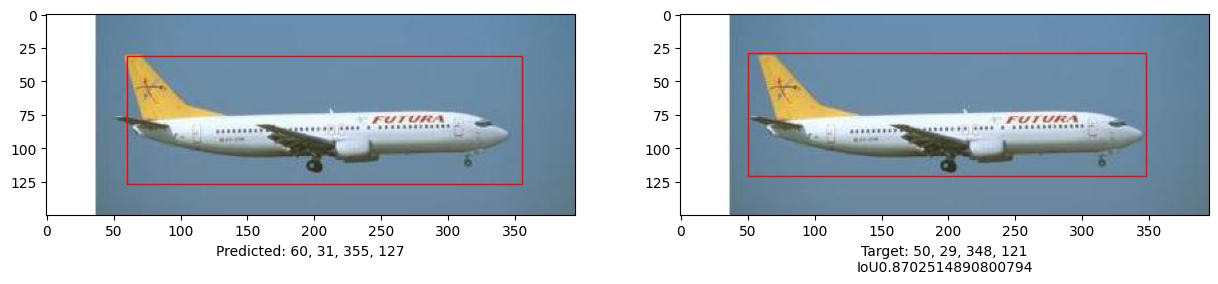

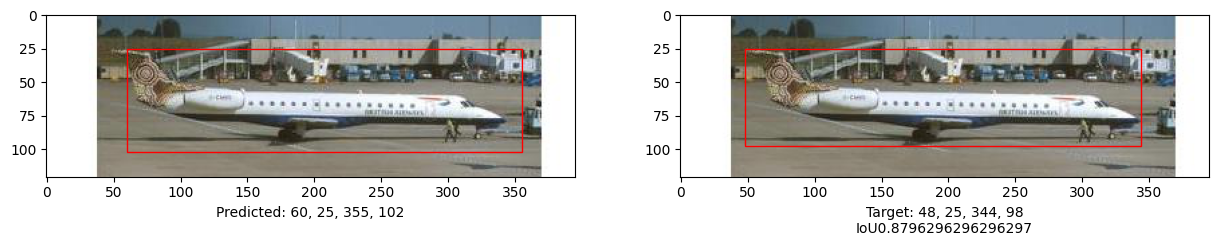

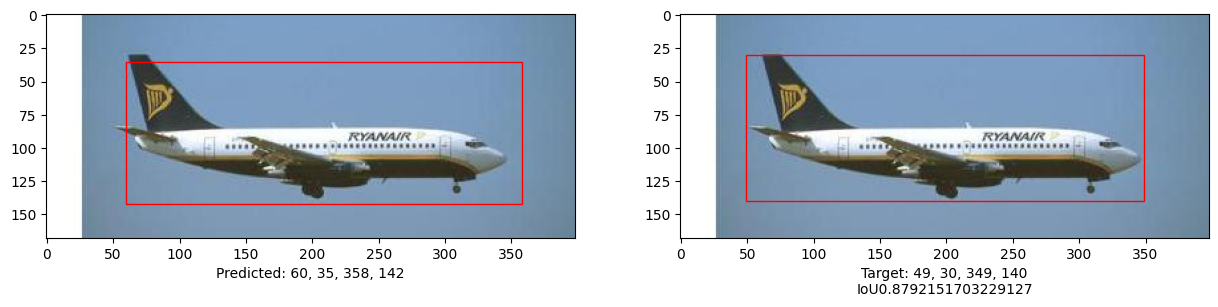

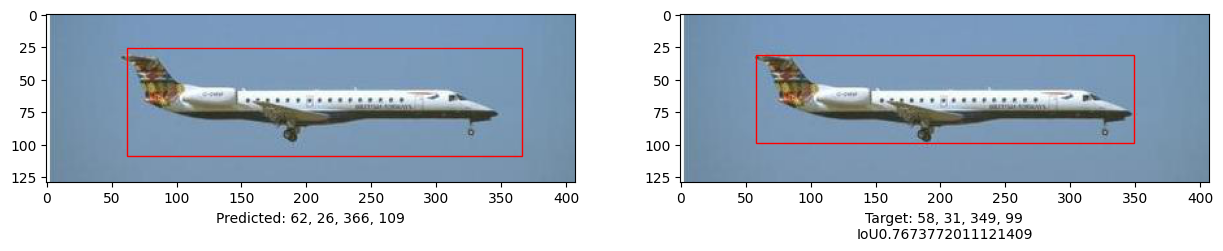

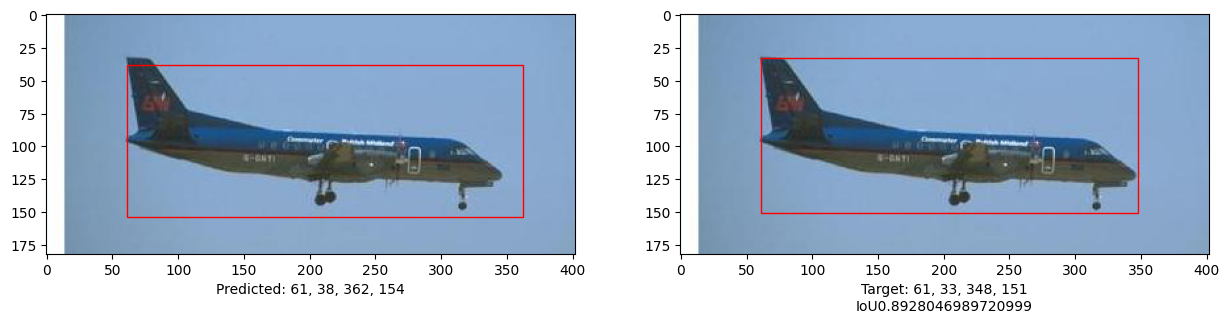

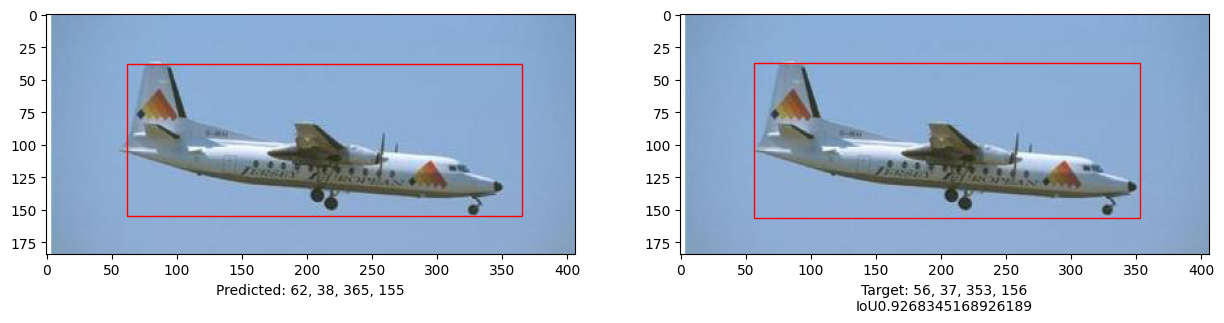

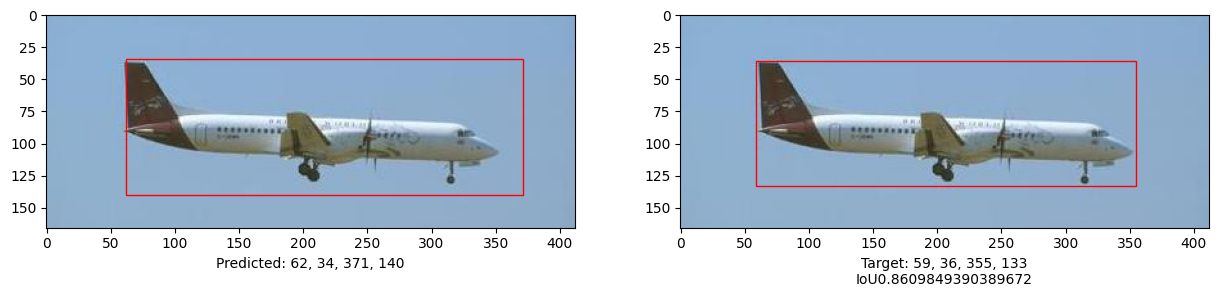

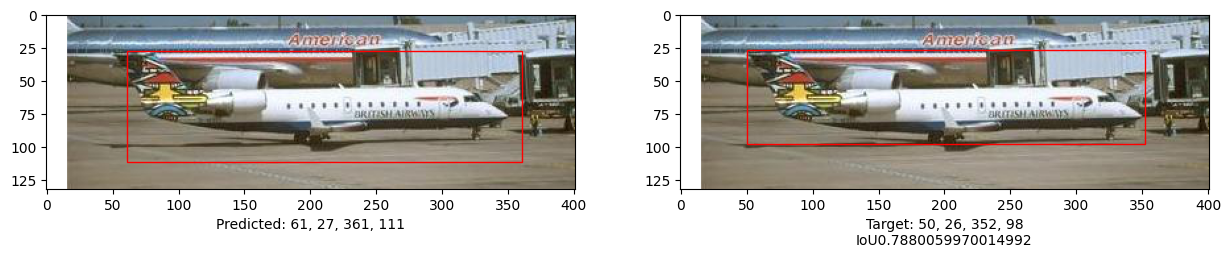

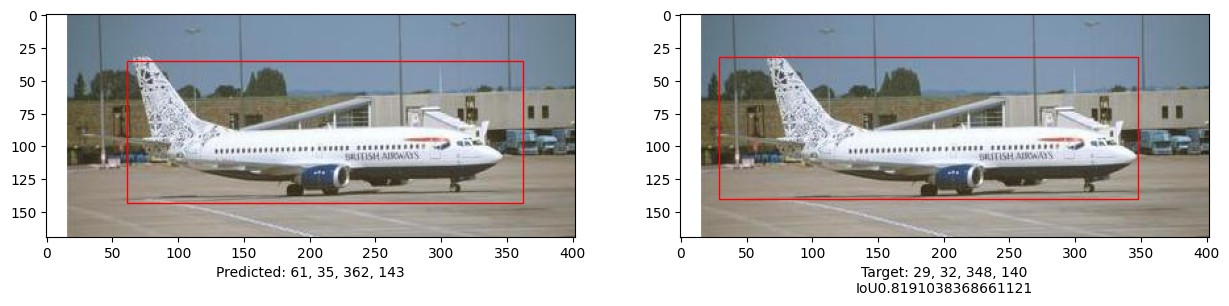

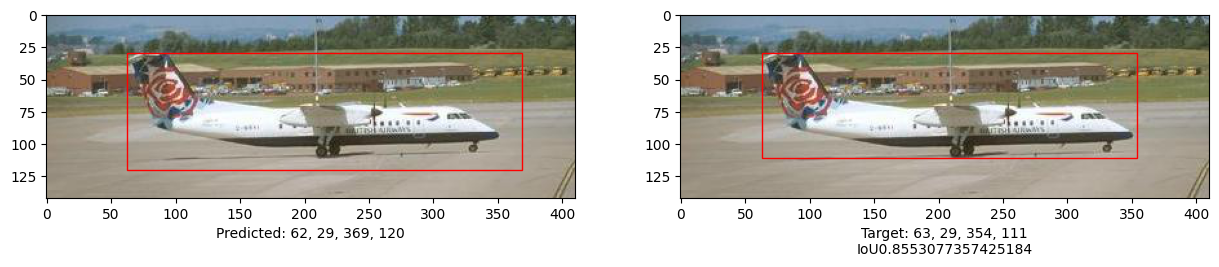

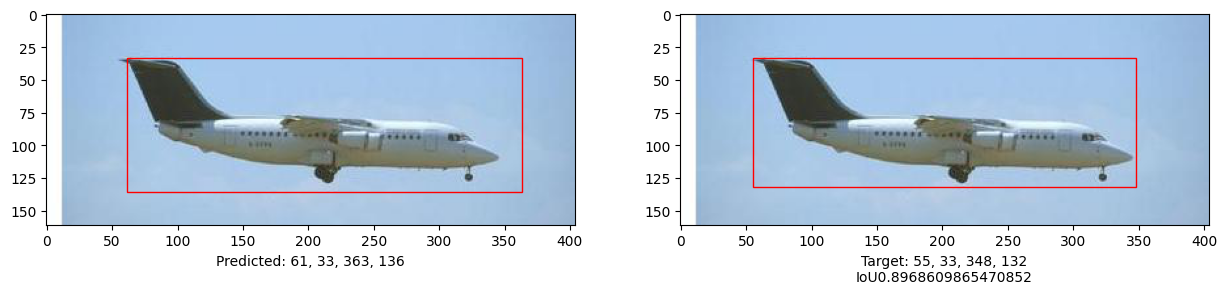

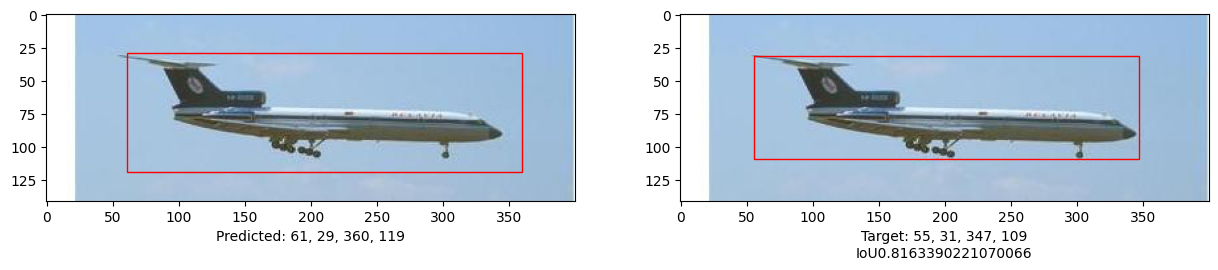

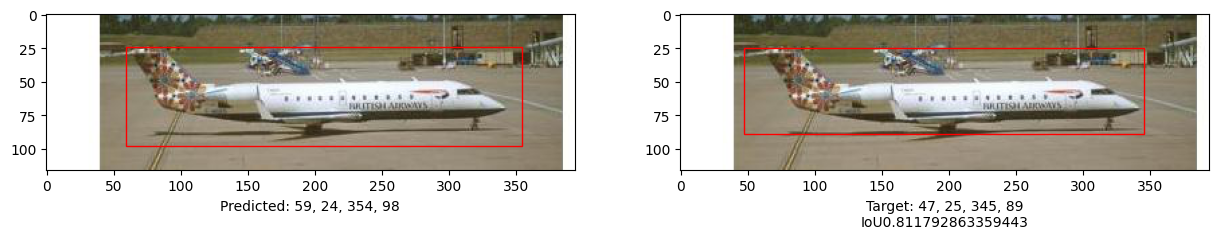

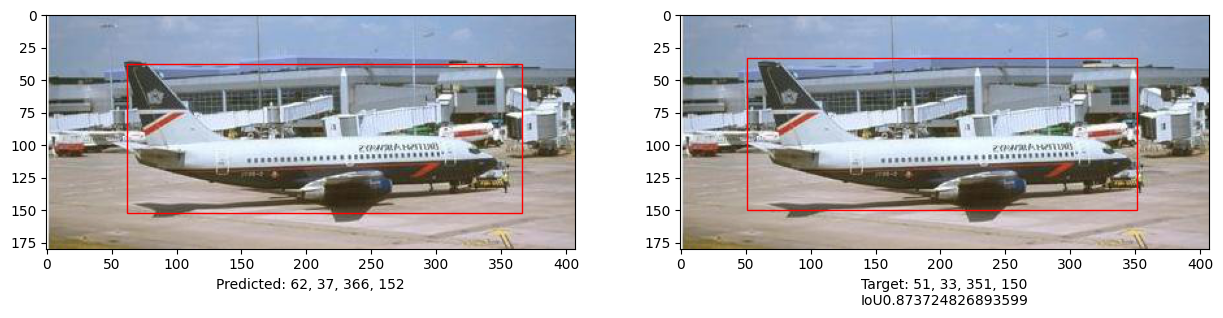

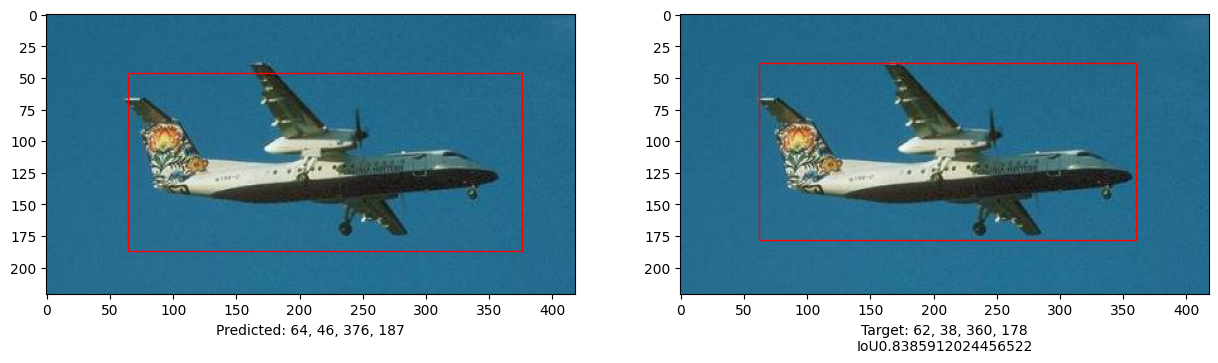

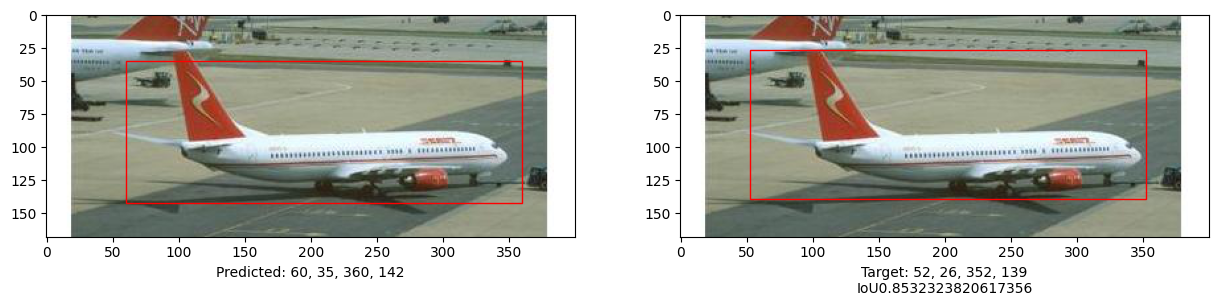

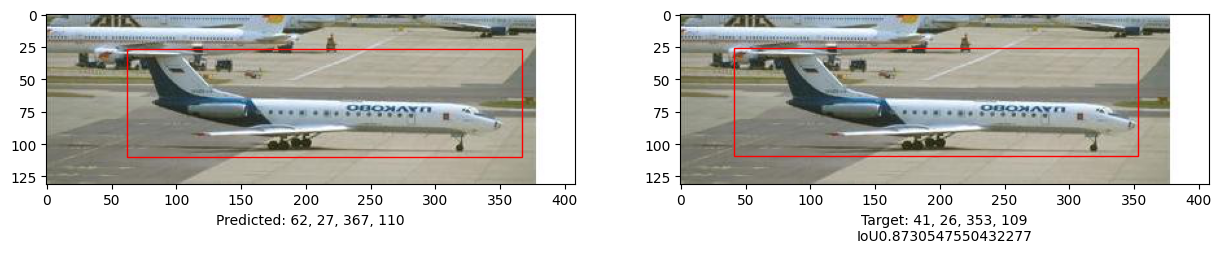

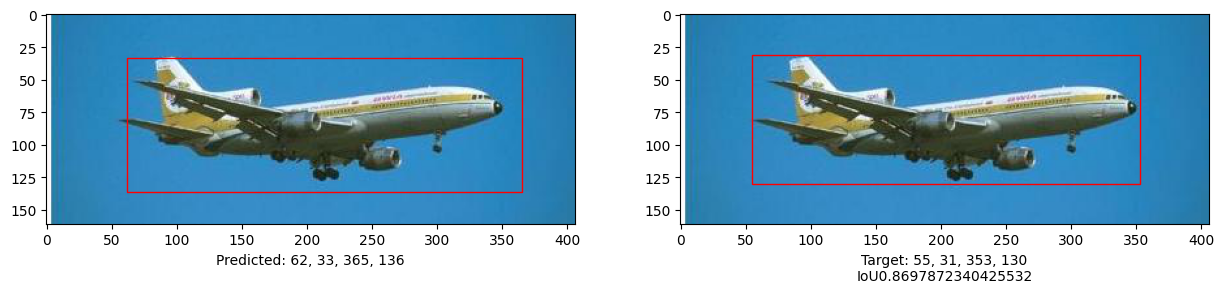

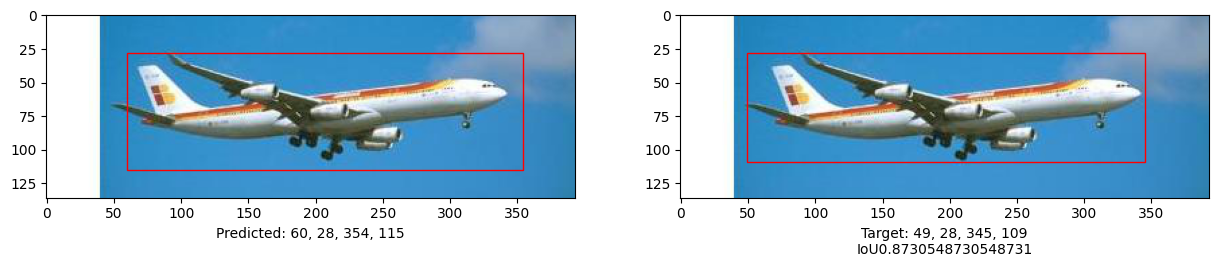

In [41]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


mean_iou = 0

# Compare results for 10 images in the test set
for i, input_image in enumerate(x_test[:20]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds_ = vit_object_detector.predict(input_image)
    
    for j, preds in enumerate(preds_):

        (h, w) = (im).shape[0:2]

        top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

        bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

        box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
        # Create the bounding box
        rect = patches.Rectangle(
            (top_left_x, top_left_y),
            bottom_right_x - top_left_x,
            bottom_right_y - top_left_y,
            facecolor="none",
            edgecolor="red",
            linewidth=1,
        )
        # Add the bounding box to the image
        ax1.add_patch(rect)
        ax1.set_xlabel(
            "Predicted: "
            + str(top_left_x)
            + ", "
            + str(top_left_y)
            + ", "
            + str(bottom_right_x)
            + ", "
            + str(bottom_right_y)
        )

        top_left_x, top_left_y = int(y_test[i][j][0] * w), int(y_test[i][j][1] * h)

        bottom_right_x, bottom_right_y = int(y_test[i][j][2] * w), int(y_test[i][j][3] * h)

        box_truth = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
        print(box_predicted, box_truth)

        mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
        # Create the bounding box
        rect = patches.Rectangle(
            (top_left_x, top_left_y),
            bottom_right_x - top_left_x,
            bottom_right_y - top_left_y,
            facecolor="none",
            edgecolor="red",
            linewidth=1,
        )
        # Add the bounding box to the image
        ax2.add_patch(rect)
        ax2.set_xlabel(
            "Target: "
            + str(top_left_x)
            + ", "
            + str(top_left_y)
            + ", "
            + str(bottom_right_x)
            + ", "
            + str(bottom_right_y)
            + "\n"
            + "IoU"
            + str(bounding_box_intersection_over_union(box_predicted, box_truth))
        )
        
print("mean_iou: " + str(mean_iou / len(x_test[:20])))
plt.show()